In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, \
    GradientBoostingClassifier, RandomForestClassifier

random_state = 44

In [273]:
df = pd.read_csv("features.csv", index_col=0)
df.dropna(inplace=True)
X = df.drop(columns=['malign', 'patient_name'])
y = df['malign']


In [274]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
scaler.transform(X)

array([[0.66872238, 0.32067174, 0.33801178, ..., 0.        , 0.        ,
        0.        ],
       [0.81503525, 0.43431311, 0.47255324, ..., 0.        , 0.        ,
        0.        ],
       [0.89418626, 0.43642804, 0.52003056, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.63515194, 0.17930703, 0.19413937, ..., 0.        , 0.        ,
        0.        ],
       [0.23890031, 0.14268305, 0.14697542, ..., 0.        , 0.        ,
        0.        ],
       [0.21205056, 0.08051066, 0.07892094, ..., 0.        , 0.        ,
        0.        ]])

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

In [276]:
tree = DecisionTreeClassifier(random_state=random_state, min_samples_split=100)
ada = AdaBoostClassifier(random_state=random_state)
bagging = BaggingClassifier(random_state=random_state)
boost = GradientBoostingClassifier(random_state=random_state)
forest = RandomForestClassifier(random_state=random_state, min_samples_split=4)

clfs = [tree, ada, bagging, boost, forest]
for clf in clfs:
    clf = clf.fit(X_train, y_train)


In [277]:
clfs_names = ['DecisionTreeClassifier', 'AdaBoostClassifier', 'BaggingClassifier', \
    'GradientBoostingClassifier', 'RandomForestClassifier']

In [278]:
# print("Tree parameters: ", clf.get_params())
# print("\n\nTree depth: ", clf.get_depth())

In [279]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_train)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_train)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_train, y_pred))
    results['F1 score'].append(f1_score(y_train, y_pred))
    results['Precision'].append(precision_score(y_train, y_pred))
    results['Recall'].append(recall_score(y_train, y_pred))

results_df = pd.DataFrame(results)
print("Performance on TRAINING set")
results_df.head(len(clfs_names))

Performance on TRAINING set


,Name,Accuracy,F1 score,Precision,Recall
0,DecisionTreeClassifier,0.871058,0.716904,0.931217,0.582781
1,AdaBoostClassifier,0.908163,0.826620,0.877323,0.781457
2,BaggingClassifier,0.976809,0.956971,0.996416,0.920530
3,GradientBoostingClassifier,0.979592,0.962457,0.992958,0.933775
4,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000


In [280]:
y_pred = clf.predict(X_val)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_val)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))

results_df = pd.DataFrame(results)
print("Performance on VALIDATION set")
results_df.head(len(clfs_names))

Performance on VALIDATION set


,Name,Accuracy,F1 score,Precision,Recall
0,DecisionTreeClassifier,0.770370,0.474576,0.608696,0.388889
1,AdaBoostClassifier,0.837037,0.645161,0.769231,0.555556
2,BaggingClassifier,0.837037,0.576923,0.937500,0.416667
3,GradientBoostingClassifier,0.844444,0.655738,0.800000,0.555556
4,RandomForestClassifier,0.866667,0.666667,1.000000,0.500000


# Macierze błędów

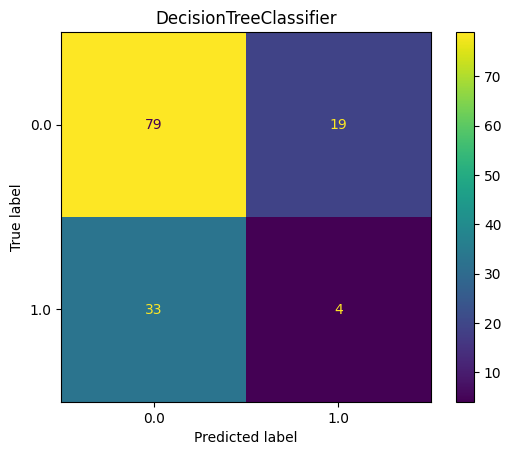

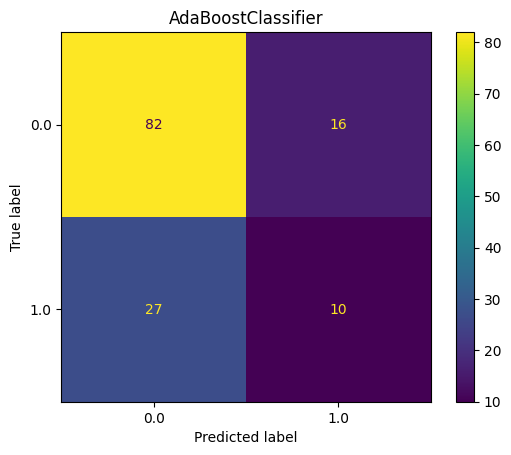

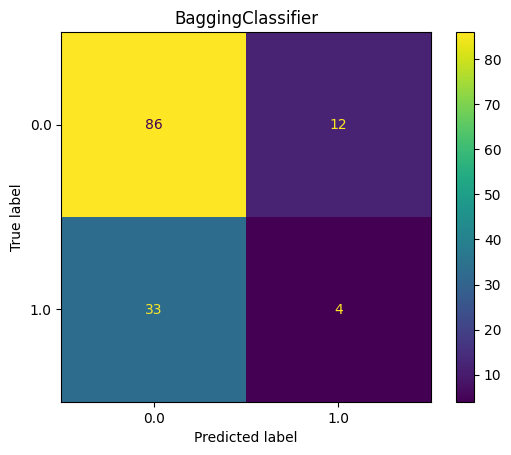

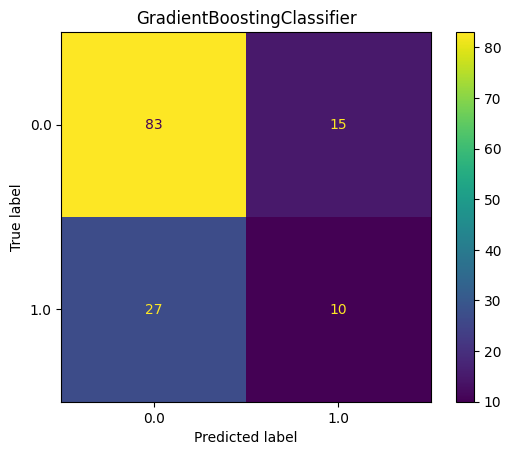

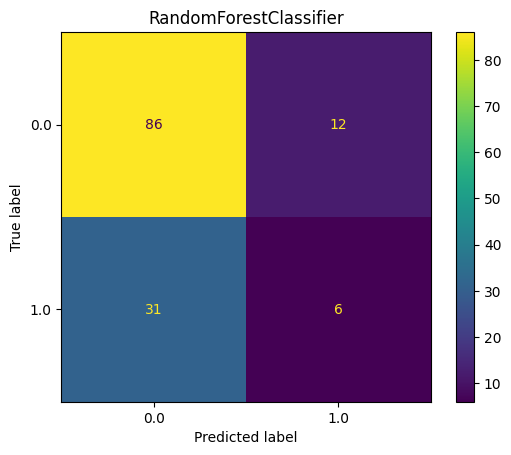

In [281]:
for clf, name in zip(clfs, clfs_names):
    y_pred = ys_pred[name]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

# Analiza krzywa charakterystyki działania odbiornika (ROC)

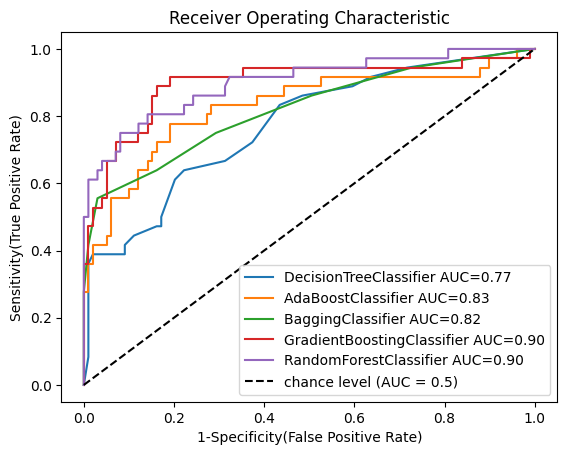

In [282]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}
clfs_thresholds = {}
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.predict_proba(X_val)
    y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    # data = {'fpr': fpr, 'trp': tpr, 'thresholds': thresholds}
    # df = pd.DataFrame(data)
    # df.head(100)
    roc_auc = auc(fpr, tpr)
    clfs_thresholds[name] = thresholds
    # display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)

    # RocCurveDisplay.from_predictions(
    #     y_val,
    #     y_pred,
    #     name=f"My threshold",
    #     color="darkorange",
    # )
    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [283]:
# data = {'fpr': fpr, 'trp': tpr, 'thresholds': thresholds}
# df = pd.DataFrame(data)
# df.head(len(fpr))

In [284]:
best_thresholds = {}
for clf, name in zip(clfs, clfs_names):
    best_f1 = 0
    best_th = None
    for threshold in clfs_thresholds[name]:
        y_pred = ys_pred_proba[name] > threshold
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_th = threshold
    best_thresholds[name] = best_th
    

In [285]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred = ys_pred_proba[name] > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on VALIDATION")
results_df.head(len(clfs_names))

Results after threshold adjustment on VALIDATION


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,DecisionTreeClassifier,0.740741,0.567901,0.511111,0.638889,0.125000
1,AdaBoostClassifier,0.792593,0.658537,0.586957,0.750000,0.494180
2,BaggingClassifier,0.859259,0.677966,0.869565,0.555556,0.400000
3,GradientBoostingClassifier,0.851852,0.756098,0.673913,0.861111,0.223017
4,RandomForestClassifier,0.866667,0.742857,0.764706,0.722222,0.348667


In [286]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}
ys_pred_test_proba = {}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results after threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,DecisionTreeClassifier,0.725926,0.584270,0.500000,0.702703,0.125000
1,AdaBoostClassifier,0.837037,0.710526,0.692308,0.729730,0.494180
2,BaggingClassifier,0.822222,0.600000,0.782609,0.486486,0.400000
3,GradientBoostingClassifier,0.822222,0.707317,0.644444,0.783784,0.223017
4,RandomForestClassifier,0.881481,0.777778,0.800000,0.756757,0.348667


In [287]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_test)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))

results_df = pd.DataFrame(results)
print("Results WITHOUT threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results WITHOUT threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall
0,DecisionTreeClassifier,0.770370,0.415094,0.687500,0.297297
1,AdaBoostClassifier,0.859259,0.698413,0.846154,0.594595
2,BaggingClassifier,0.822222,0.538462,0.933333,0.378378
3,GradientBoostingClassifier,0.851852,0.677419,0.840000,0.567568
4,RandomForestClassifier,0.829630,0.596491,0.850000,0.459459


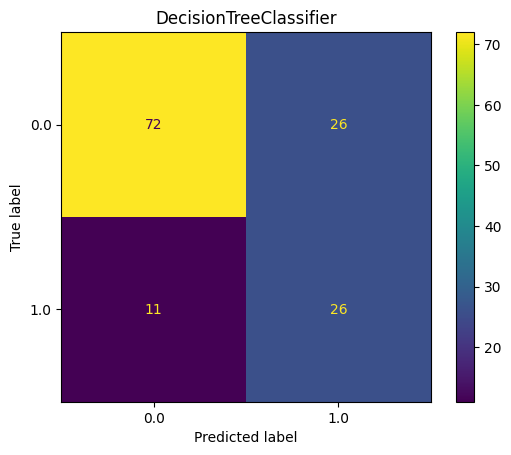

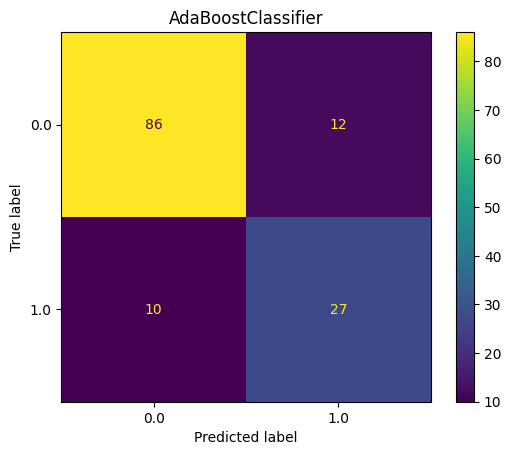

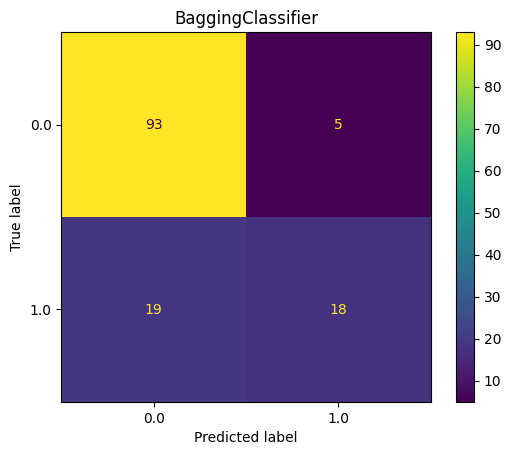

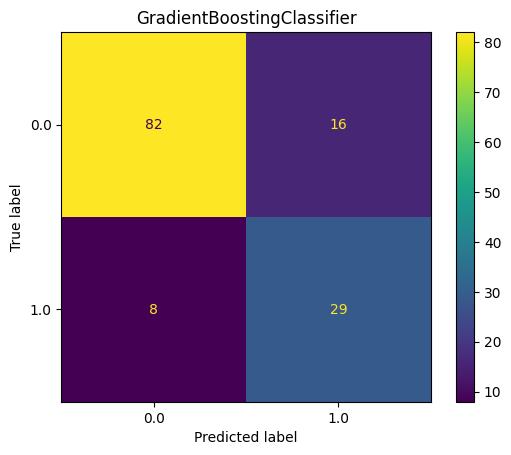

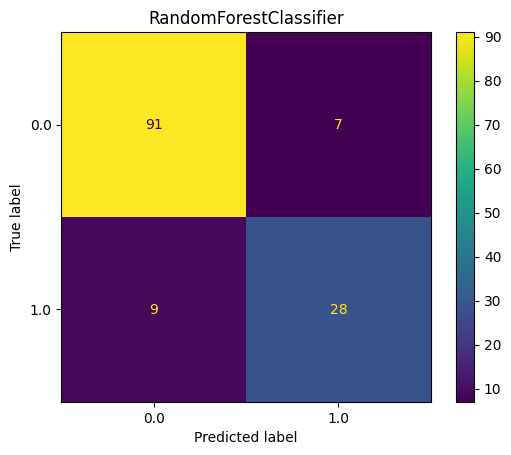

In [288]:
for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()